# Open Data Cube - Max NDVI Notebook

**Description:** This Python notebook allows users to directly interact with an Open Data Cube to calculate max NDVI

## Import libraries

In [1]:
# %matplotlib inline
%pylab notebook

from matplotlib import pyplot as plt
import ipywidgets as widgets

from datetime import datetime
import numpy as np
import gc
import warnings

import datacube
from datacube.storage import masking
import xarray as xr

Populating the interactive namespace from numpy and matplotlib


## Link to your Data Cube

In [2]:
from datacube import Datacube
dc = datacube.Datacube()

# Define functions

## Calculate NDVI

In [3]:
def ndvi(dataset_in):
    def _band_ratio(a, b):
        """
        Calculates a normalized ratio index
        """
        return (a - b) / (a + b)
    
    red = dataset_in.red
    nir = dataset_in.nir

    dtype = red.values.dtype 
    shape = red.values.shape

    no_data =-9999

    data_array = _band_ratio(nir, red)

    dataset_out = xr.Dataset({'ndvi': data_array})
    return dataset_out


## Retrieving Surface reflectance, Cloud Filtering and Cloud Masking

In [4]:
def load_combine_mask_discard(sensors, bands_of_interest, query, cloud_free_threshold):  
    sensor_clean = {}
    for sensor in sensors: #loop through specified sensors
        sensor_sr = dc.load(product= sensor+'_usgs_sr_scene',
                               measurements = bands_of_interest,group_by='solar_day', 
                               **query) 
        
        # if no data found for sensor skip it
        if not sensor_sr.data_vars:
            print('skipping %s' % sensor) 
            continue
        
        #retrieve the projection information before masking/sorting so we can add it back later
        crs = sensor_sr.crs
        affine = sensor_sr.affine
        
        #assign pq data variable
        sensor_pq= sensor_sr.pixel_qa
        
        # Convert No-Data values to NaNs
        sensor_sr = masking.mask_invalid_data(sensor_sr)
        
        #create cloud mask
        cloud_free = masking.make_mask(sensor_pq, cloud_shadow= 'no_cloud_shadow',cloud= 'no_cloud')
        
        del sensor_pq
        
        #discard data that does not meet the cloud_free_threshold
        masked_data = sensor_sr.where(cloud_free).dropna(dim='time', thresh=cloud_free_threshold*cloud_free.x.size*cloud_free.y.size)
        
        del sensor_sr
        
        #assign masked data to array
        sensor_clean[sensor] = masked_data
        
        del masked_data

        print('loaded %s' % sensor) 
    
    #combine sensors and sort by time
    sr_clean = xr.concat(sensor_clean.values(), 'time')
    del sensor_clean
    sr_clean = sr_clean.sortby('time')
        
    
    #apply projection information to resulting xarray
    sr_clean.attrs['crs'] = crs
    sr_clean.attrs['affine'] = affine
    return sr_clean

# Query and extract data from Data Cube

In [5]:
#Some example areas of interest
lacantan_bounds = {
    'x': (-91.1621, -91.0011),
    'y': (15.9977, 16.1652)
}

sisal_bounds = {
    'x': (-90.0688, -89.9758),
    'y': (21.1057, 21.1975)
}

lake_cuitzeo_bounds = {
    'x': (-101.3879, -101.1072),
    'y': (19.7894, 20.0734)
}

grande_de_santiago_river_bounds = {
    'x': (-105.4834, -105.3600),
    'y': (21.5759, 21.7016)
}


In [6]:
# Lets look at the grande de santiago river
aoi_bounds = grande_de_santiago_river_bounds

In [7]:
#Query is created
query = {'time': ('2017-01-01', '2017-12-31'),}
query['x'] = aoi_bounds['x']
query['y'] = aoi_bounds['y']
query['crs'] = 'EPSG:4326'
query['resolution'] = (-30, 30)
query['output_crs'] = 'EPSG:32616'

#The bands required for NDVI
bands_of_interest = ['red', 'nir','pixel_qa']

#set cloud free threshold
cloud_free_threshold = 0.10

#define Landsat sensors of interest
sensors = ['ls8','ls7','ls5'] 

In [8]:
#Load clean surface reflectance data from Data Cube
sr_clean = load_combine_mask_discard(sensors, bands_of_interest, query, cloud_free_threshold)

loaded ls8
loaded ls7
skipping ls5


# Calculate NDVI and Max NDVI

## Calculate NDVI

In [9]:
#Use water clasifier function created above
warnings.filterwarnings('ignore') #turn off warnings
ndvi = ndvi(sr_clean) #use function
warnings.filterwarnings('always') #turn on warnings

## Calculate and plot Max NDVI

In [10]:
max_ndvi = ndvi.ndvi.max(dim='time')

In [13]:
#Set up colour ramp details
max_ndvi_bounds = [-1, 0.3, 1]

<IPython.core.display.Javascript object>


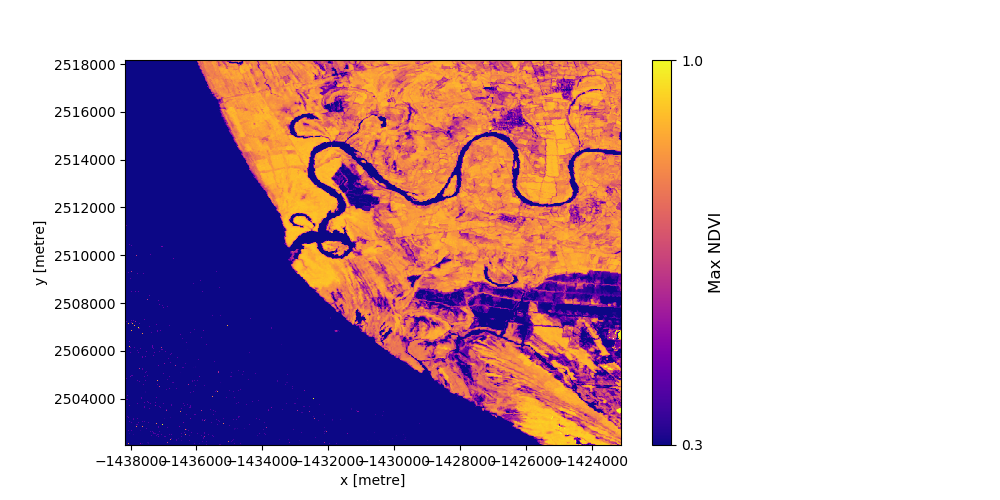

In [14]:
#Create max_ndvi image with specified colour ramp details
fig = plt.figure(figsize =(10,5)) 
i=max_ndvi.plot.imshow(cmap = 'plasma',vmin = 0.3, vmax = 1)
plt.colorbar(i, ticks=max_ndvi_bounds, 
            ).set_label(label='Max NDVI',
             size=12) #Add definable colour bar
fig.delaxes(fig.axes[1]) #Remove pre-defined colour bar

plt.show() #Create image